<a href="https://colab.research.google.com/github/ryunino/competition-code/blob/master/kaggle_titanic_AUCipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/

import numpy as np
import pandas as pd
import random

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from six import StringIO
from sklearn.metrics import roc_auc_score
from sklearn.tree import plot_tree
#from sklearn.impute import SimpleImputer

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import math
from scipy import stats

from mpl_toolkits.mplot3d import Axes3D


# Set Display Max Columns
pd.set_option("display.max_columns", 50)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [ ]:
#データ前処理
train = pd.read_csv(r"./dsws/motodata/titanic_train.csv")

test = pd.read_csv("./dsws/motodata/titanic_test.csv")

train = train.rename(columns = {'Survived' : 'y'})
test = test.rename(columns = {'Survived' : 'y'})

#欠損値処理
#print(train.isna().sum())
train['Embarked02']=train['Embarked'].fillna('N')
test['Embarked02']=test['Embarked'].fillna('N')
test['Fare'] = test['Fare'].fillna(
    train['Fare'].mean()
)

def age(x) :
    if x < 10 :
        return 0
    elif x < 20 :
        return 10
    elif x < 30 :
        return 20
    elif x < 40 :
        return 30
    elif x < 50 :
        return 40
    elif x < 60 :
        return 50
    elif x < 70 :
        return 60
    elif x < 80 :
        return 70
    elif x < 90 :
        return 80
    else :
        return 100

train['Age02'] = train['Age'].apply(lambda x : age(x))
train['Sex'] = train['Sex'].map({'male':0,'female':1})
train['Embarked02'] = train['Embarked02'].map({'S':0,'C':1, 'Q':2, 'N':3})

test['Age02'] = test['Age'].apply(lambda x : age(x))
test['Sex'] = test['Sex'].map({'male':0,'female':1})
test['Embarked02'] = test['Embarked02'].map({'S':0,'C':1, 'Q':2, 'N':3})

train = train.drop(['Name','Ticket','Cabin', 'Embarked', 'Age', 'Embarked02', 'Age02', 'Parch', 'SibSp'],axis=1)
test = test.drop(['Name','Ticket','Cabin', 'Embarked', 'Age', 'Embarked02', 'Age02', 'Parch', 'SibSp'],axis=1)

print(train.isna().sum())
print(test.isna().sum())

train.head()

PassengerId    0
y              0
Pclass         0
Sex            0
Fare           0
dtype: int64
PassengerId    0
Pclass         0
Sex            0
Fare           0
dtype: int64


,PassengerId,y,Pclass,Sex,Fare
0,1,0,3,0,7.2500
1,2,1,1,1,71.2833
2,3,1,3,1,7.9250
3,4,1,1,1,53.1000
4,5,0,3,0,8.0500


y              1.000000
Sex            0.543351
Pclass         0.338481
Fare           0.257307
PassengerId    0.005007
Name: y, dtype: float64


Text(0.5, 1.0, 'Correlation Matrix')

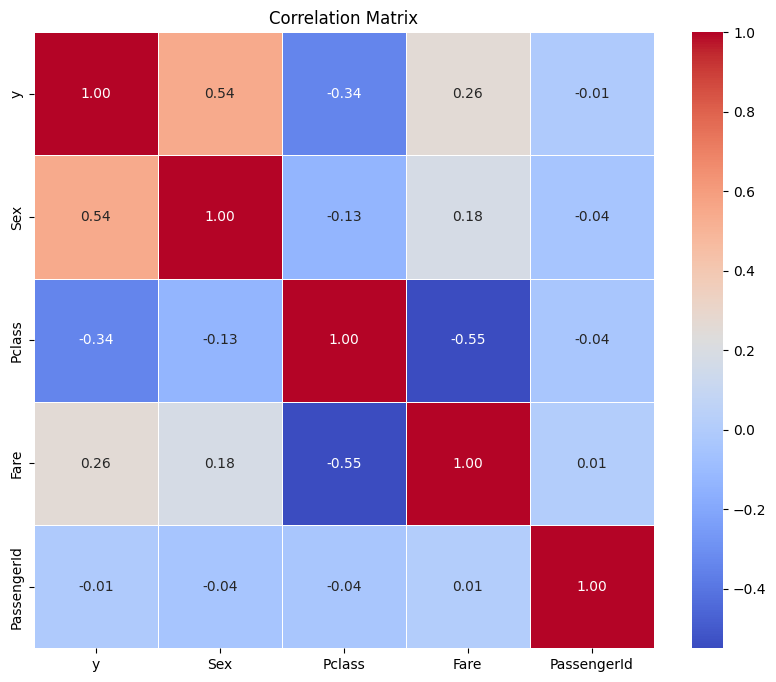

In [ ]:
#相関分析
corr_matrix_train_temp = train.corr()

corr_train_sorted = corr_matrix_train_temp['y'].abs().sort_values(ascending=False)
print(corr_train_sorted)

train = train[corr_train_sorted.index]
corr_matrix_train = train.corr()

plt.figure(figsize=(10,8))
sns.heatmap(
    corr_matrix_train,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5
    )

plt.title('Correlation Matrix')

In [ ]:
#hold out

train_train = train.sample(frac = 0.7, random_state = 10)
train_valid = train[~train['PassengerId'].isin(train_train['PassengerId'])]

train_train = train_train.drop(['PassengerId'],axis=1)
train_valid = train_valid.drop(['PassengerId'],axis=1)

train_train_x = train_train.drop(columns=["y"])
train_train_y = train_train[["y"]]

train_valid_x = train_valid.drop(columns=["y"])
train_valid_y = train_valid[["y"]]

xyz値: (4, 2, 12)


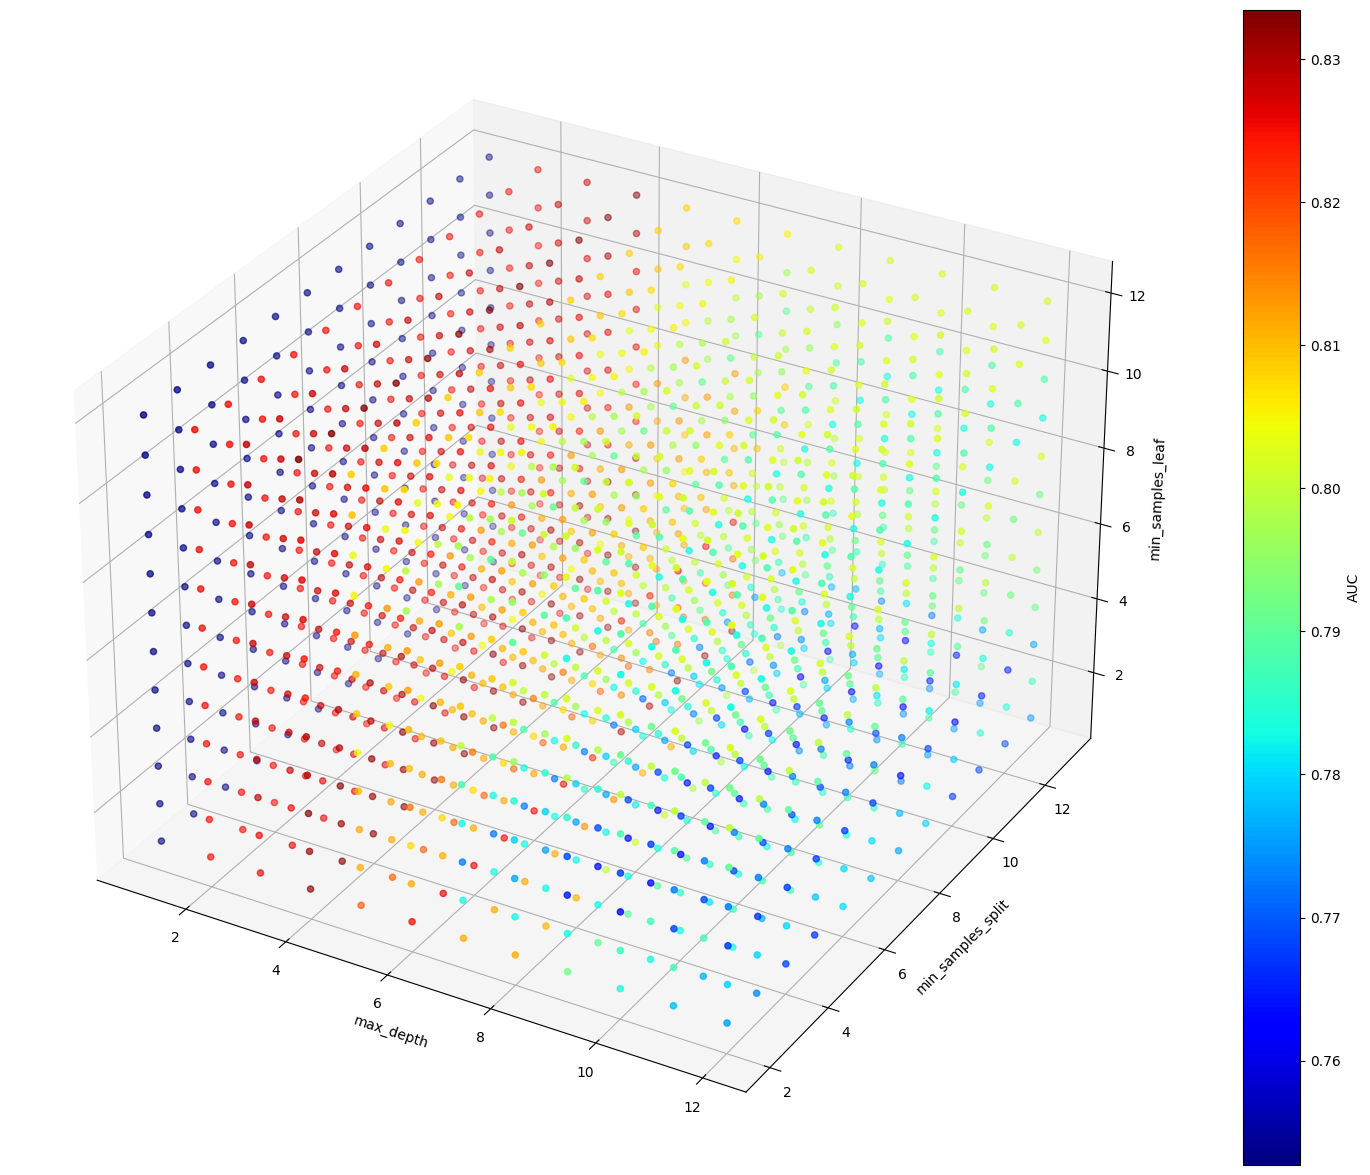

In [ ]:
"""パラメータになり得るもの
frac                        # テストモデルの量
criterion                   # 分割の品質
    ”gini”, "entropy", “log_loss”
splitter                    # 分割
    “best”, “random”
random_state                # 同じ分割スコアの時にランダムに選ぶseedを固定
max_depth                   # 決定木の深さの最大値
min_samples_split           # 分割する最小データ数
min_samples_leaf            # 末端ノードに該当する最小サンプル数
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
"""

# Cross Validation
train_scores = []
valid_scores = []
parameters = []


for j in range(12):
    for k in range(12):
        for l in range(12):
            train_x = train_train.drop(columns=["y"])
            train_y = train_train[["y"]]

            valid_x = train_valid.drop(columns=["y"])
            valid_y = train_valid[["y"]]

            # Make Model
            tree_model04 = DecisionTreeClassifier(
                criterion = "gini",
                splitter = "best",
                random_state = 17,
                max_depth = j + 1,
                min_samples_split = k + 2,
                min_samples_leaf = l + 1
            )
            tree_model04 = tree_model04.fit(train_x, train_y)

            # 構築データのAUC
            pred_train = tree_model04.predict_proba(train_x)[:, 1]
            train_auc = roc_auc_score(train_y, pred_train)

            # 検証データのAUC
            pred_valid = tree_model04.predict_proba(valid_x)[:, 1]
            valid_auc = roc_auc_score(valid_y, pred_valid)

            # 結果を保存
            train_scores.append(train_auc)
            valid_scores.append(valid_auc)
            parameters.append((j + 1, k + 2, l + 1))

#　おすすめパラメータの設定
ave_score = [(x + y) / 2 for x, y in zip(train_scores, valid_scores)]
abs_diff_list = [abs(x - y) for x, y in zip(train_scores, valid_scores)]
score = [x - y for x, y in zip(ave_score, abs_diff_list)]
max_index = np.argmax(score)
max_xyz = parameters[max_index]
print("xyz値:", max_xyz)

# データの準備
x = [coord[0] for coord in parameters]
y = [coord[1] for coord in parameters]
z = [coord[2] for coord in parameters]

# グラフの描画
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection='3d')

# スコアを0から1までのグラデーションで色付けしてプロット
ax.scatter(x, y, z, c=score, cmap='jet')

# 軸ラベルの設定
ax.set_xlabel('max_depth')
ax.set_ylabel('min_samples_split')
ax.set_zlabel('min_samples_leaf')

# カラーバーの表示
cbar = plt.colorbar(ax.collections[0])
cbar.set_label('AUC')

# グラフの表示
plt.show()

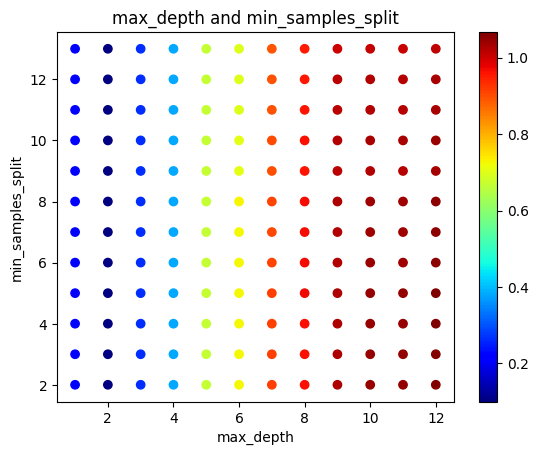

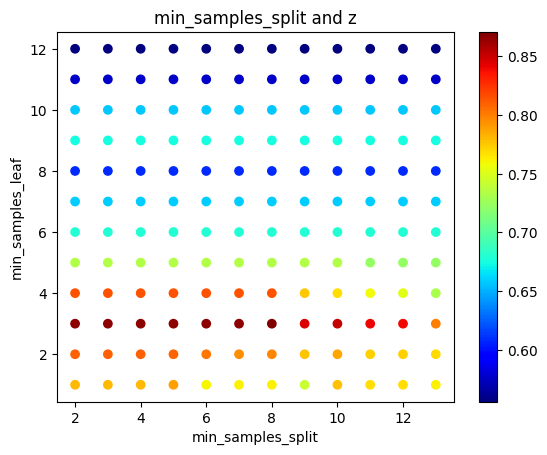

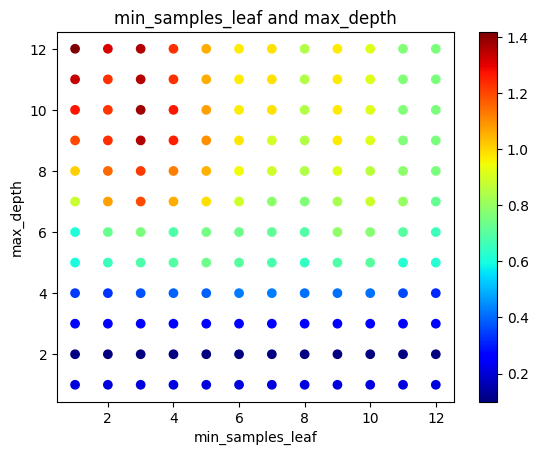

In [ ]:
xyz = parameters

abs_diff_list = [abs(x - y) for x, y in zip(train_scores, valid_scores)]

score = abs_diff_list

# xとyが同じ値の場合のグラフ
xy_dict = {}
for i in range(len(xyz)):
    x, y, z = xyz[i]
    if (x, y) not in xy_dict:
        xy_dict[(x, y)] = score[i]
    else:
        xy_dict[(x, y)] += score[i]

xy_values = np.array(list(xy_dict.keys()))
xy_scores = np.array(list(xy_dict.values()))

plt.scatter(xy_values[:, 0], xy_values[:, 1], c=xy_scores, cmap='jet')
plt.xlabel('max_depth')
plt.ylabel('min_samples_split')
plt.title('max_depth and min_samples_split')
plt.colorbar()
plt.show()

# yとzが同じ値の場合のグラフ
yz_dict = {}
for i in range(len(xyz)):
    x, y, z = xyz[i]
    if (y, z) not in yz_dict:
        yz_dict[(y, z)] = score[i]
    else:
        yz_dict[(y, z)] += score[i]

yz_values = np.array(list(yz_dict.keys()))
yz_scores = np.array(list(yz_dict.values()))

plt.scatter(yz_values[:, 0], yz_values[:, 1], c=yz_scores, cmap='jet')
plt.xlabel('min_samples_split')
plt.ylabel('min_samples_leaf')
plt.title('min_samples_split and z')
plt.colorbar()
plt.show()

# zとxが同じ値の場合のグラフ
zx_dict = {}
for i in range(len(xyz)):
    x, y, z = xyz[i]
    if (z, x) not in zx_dict:
        zx_dict[(z, x)] = score[i]
    else:
        zx_dict[(z, x)] += score[i]

zx_values = np.array(list(zx_dict.keys()))
zx_scores = np.array(list(zx_dict.values()))

plt.scatter(zx_values[:, 0], zx_values[:, 1], c=zx_scores, cmap='jet')
plt.xlabel('min_samples_leaf')
plt.ylabel('max_depth')
plt.title('min_samples_leaf and max_depth')
plt.colorbar()
plt.show()

train AUC: 0.8732692558888839
test AUC: 0.8467142520056631


,Id,Predicted
0,1,0.323529
1,2,0.323529
2,3,0.323529
3,4,0.923077
4,5,0.310680
...,...,...
411,412,0.121622
412,413,0.121622
413,414,0.121622
414,415,0.083333


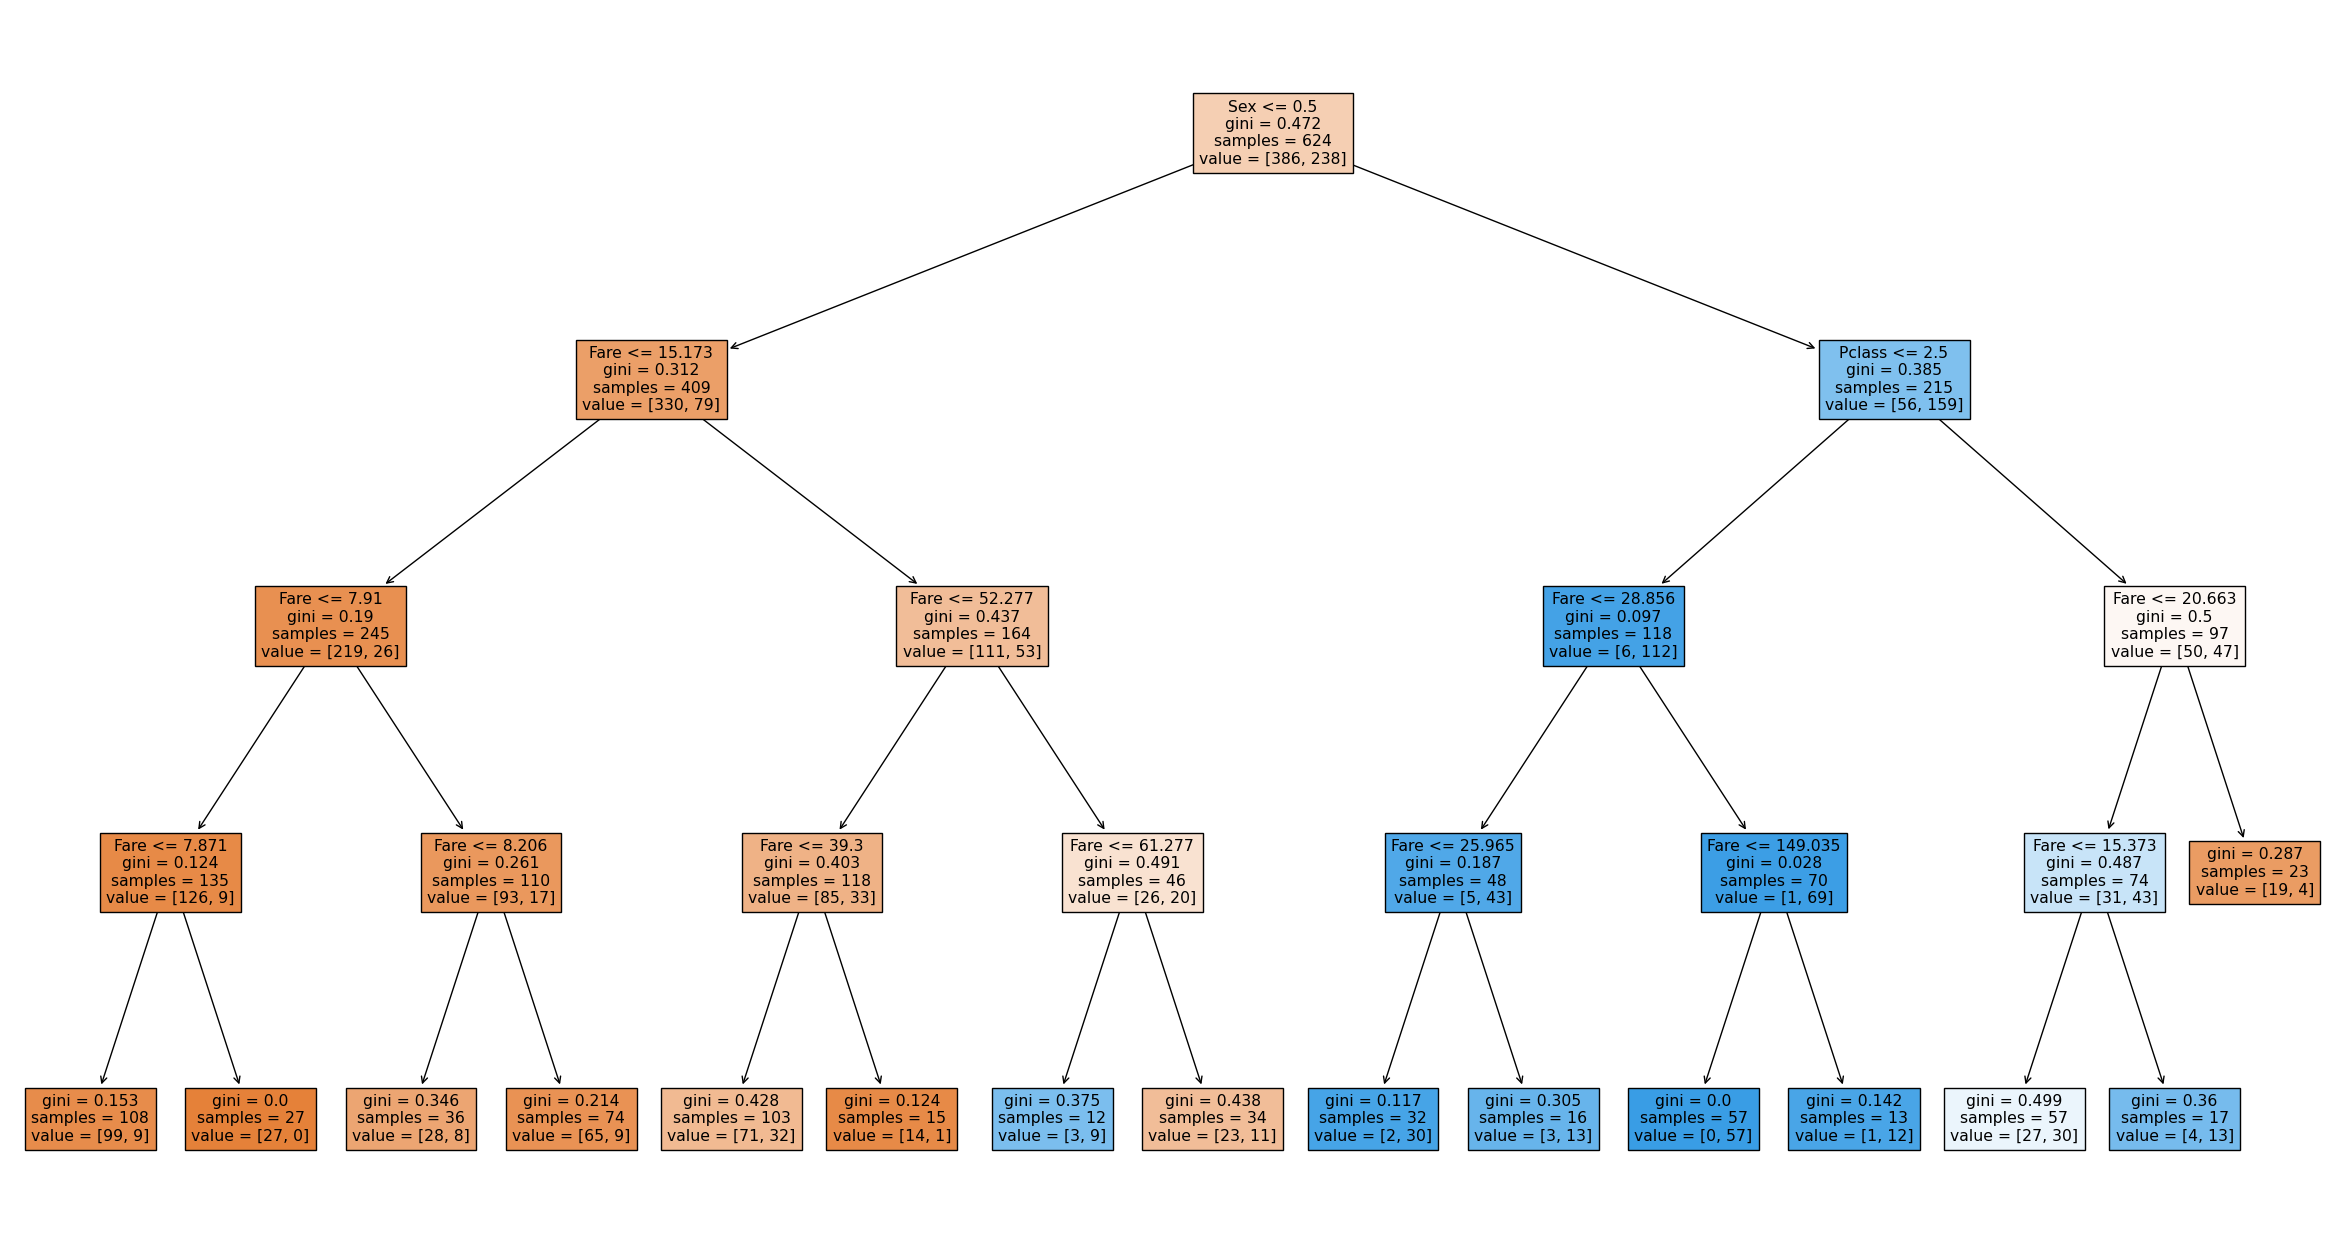

In [ ]:
#決定木モデルの作成

col_name = list(train_train_x.columns)

# モデルのパラメータを設定する（モデルのインスタンスを生成）
tree_model = DecisionTreeClassifier(
    criterion="gini",            # GINI基準の場合は"gini”
    splitter="best",             # 分割をランダムで行う場合は"random"best
    random_state=10,             # 同じ分割スコアの時にランダムに選ぶseedを固定
    max_depth=max_xyz[0],                 # 決定木の深さの最大値
    min_samples_split=max_xyz[1],       # 分割する最小データ数
    min_samples_leaf=max_xyz[2]         # 末端ノードに該当する最小サンプル数
)

# 上記で生成したモデルのインスタンスを使い学習用データで学習する
tree_model = tree_model.fit(train_train_x, train_train_y)

# scikit-learn 0.21以降から実装された
fig = plt.figure(figsize=(30, 16))
ax = fig.add_subplot()
plot_tree(tree_model, feature_names=col_name, ax=ax, filled=True) #feature_namesのところで、先ほど取り出しておいた 'col_name'を使っています。

pred_train = tree_model.predict_proba(train_train_x)[:, 1]
print("train AUC:", roc_auc_score(train_train_y, pred_train))

pred_train_vaild = tree_model.predict_proba(train_valid_x)[:, 1]
print("test AUC:", roc_auc_score(train_valid_y, pred_train_vaild))

#提出用テストデータによる検証
test_x = test
test_x = test_x[train_train_x.columns]

pred_test = tree_model.predict_proba(test_x)[:, 1]
submission = pd.DataFrame(pred_test)
submission = submission.reset_index()
submission["index"] = submission["index"]+1
submission.columns = ["Id", "Predicted"]

submission.to_csv(
      path_or_buf = r"./dsws/submit/submit_tree_20240208_04.csv",
      sep = ",",
      index = False,
      header = True
)

submission